In [25]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.induction_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data_and_feed
from typing import Optional, Union
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
from tqdm import tqdm 

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def plot_feed(feeds):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], align='edge')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Feed (mL/h)')
    ax.set_title('Feed vs Time')
    plt.show()
    
def plot_simulation(t: Optional[list] = None, y: Optional[list] = None, full_df: Optional[pd.DataFrame] = None, train_df: Optional[pd.DataFrame] = None, net_df: Optional[pd.DataFrame] = None, title: Optional[str] = None):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    
    if t is not None and y is not None:
        ax1.plot(t, y[0], label='Biomass (ODE)', alpha=0.6)
        ax1.plot(t, y[1], label='Glucose (ODE)', alpha=0.6)
        ax2.plot(t, y[2], label='Protein (ODE)', alpha=0.6)
        ax3.plot(t, y[3], label='Volume (ODE)', alpha=0.6)
    
    if full_df is not None:
        ax1.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (EXP)', color='red', alpha=0.2)   
        ax1.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (EXP)', color='green', alpha=0.2)
        ax2.scatter(full_df['RTime'], full_df['Protein'], label='Protein (EXP)', color='blue', alpha=0.2)
        ax3.scatter(full_df['RTime'], full_df['V'], label='Volume (EXP)', color='purple', alpha=0.2)
    
    if train_df is not None:
        ax1.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)   
        ax1.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
        ax2.scatter(train_df['RTime'], train_df['Protein'], label='Protein (Train)', color='blue', alpha=1)
        ax3.scatter(train_df['RTime'], train_df['V'], label='Volume (Train)', color='purple', alpha=1)
    
    if net_df is not None:
        ax1.scatter(net_df['RTime'], net_df['Glucose'], label='Glucose (Predicted)', marker='x', color='red', alpha=0.5)
        ax1.scatter(net_df['RTime'], net_df['Biomass'], label='Biomass (Predicted)', marker='x', color='green', alpha=0.5)
        ax2.scatter(net_df['RTime'], net_df['Protein'], label='Protein (Predicted)', marker='x', color='blue', alpha=0.5)
        ax3.scatter(net_df['RTime'], net_df['V'], label='Volume (Predicted)', marker='x', color='purple', alpha=0.5)

    ax1.set_xlabel("Time (hours)")
    ax1.set_ylabel("Concentration")
    ax1.legend()
    
    ax2.set_xlabel("Time (hours)")
    ax2.set_ylabel("Concentration")
    ax2.legend()

    ax3.set_xlabel("Time (hours)")
    ax3.set_ylabel("Volume")
    ax3.legend()
        
    plt.show()
 
def get_feed(feeds: pd.DataFrame, time: float) -> float:
    for _, row in feeds.iterrows():
        start_time = row["Time"]
        end_time = row["Time"] + row["Duration"]
        if start_time <= time < end_time:
            return row["F"] / 1000
    return 0

def simulate(df: pd.DataFrame, feeds: pd.DataFrame, \
             mu_max, Ks, Yxs, c1, c2, plot: bool = True):
    
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    Sin = 1.43 * 200

    def alpha(t):
        return c1 * (1 - np.exp(-c2 * t**2))

    def system_ode(t, y):
        X, S, P, V = y
        mu = mu_max * S / (Ks + S)
        F = get_feed(feeds, t)
        dXdt = mu * X + F * X / V
        dSdt = - mu * X / Yxs + F * (Sin - S) / V
        dPdt = alpha(t) * X - P * F / V
        dVdt = F
        return [dXdt, dSdt, dPdt, dVdt]
    
    t_start, t_end = df['RTime'].min(), df['RTime'].max()
    t_span = (t_start, t_end)
    y0 = [df['Biomass'].iloc[0], df['Glucose'].iloc[0], \
          df['Protein'].iloc[0], df['V'].iloc[0]]

    t_eval = np.linspace(t_start, t_end, 10000)
    sol = solve_ivp(system_ode, t_span=t_span, \
        y0=y0, t_eval=t_eval)
    
    if plot:
        plot_simulation(sol.t, sol.y, full_df=df)

    for i in range(sol.y.shape[0]):
        sol.y[i][sol.y[i] < 0] = 0

    return sol

def get_predictions_df(net: nn.Module, df: pd.DataFrame):
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df['RTime'].values
    t_test = numpy_to_tensor(t_test)
    net_df["RTime"] = df["RTime"].values
    net_df["Biomass"] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df["Glucose"] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    net_df["V"] = net.forward(t_test).detach().cpu().numpy()[:, 2]
    net_df["Protein"] = net.forward(t_test).detach().cpu().numpy()[:, 3]
    net_df.loc[net_df['Glucose'] < 0, 'Glucose'] = 0
    return net_df

In [27]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR04'

df, feeds = get_data_and_feed(FILENAME, EXPERIMENT)

# Only FED-BATCH-INDUCTION data
df = df[df['Process'] == 'FBI']
feeds = feeds[feeds['Induction']==1]

print(f'Dataset shape: {df.shape}')

Dataset shape: (6, 8)


In [28]:
def main(df: pd.DataFrame, num_epochs: int = 2500):
    t_start, t_end = df['RTime'].min(), df['RTime'].max()

    t_train = numpy_to_tensor(df['RTime'].values)
    Biomass_train = numpy_to_tensor(df['Biomass'].values)
    Glucose_train = numpy_to_tensor(df['Glucose'].values)
    V_train = numpy_to_tensor(df['V'].values)
    Protein_train = numpy_to_tensor(df['Protein'].values)
    u_train = torch.cat((Biomass_train, Glucose_train, V_train, Protein_train), 1)

    net = PINN(input_dim=1, output_dim=4, t_start=t_start, t_end=t_end)

    net = train(net, t_train, u_train, df, feeds, \
                num_epochs=num_epochs, verbose=True)

    net_df = get_predictions_df(net, df)     

    sol = simulate(df, feeds, net.mu_max.item(), net.K_s.item(), net.Y_xs.item(), \
               c1=net.c1.item(), c2=net.c2.item(), plot=False)

    title = f'c1 = {net.c1.item():.4f}, c2 = {net.c2.item():.4f}'
    plot_simulation(full_df=df, net_df=net_df, t=sol.t, y=sol.y, title=title)
    
    return net, net_df

In [29]:
def V(t):
    return 31/1000 * (t-9.933333) + 1.422819

df['V'] = V(df['RTime'])
df

,Process,RTime,Glucose,Biomass,Protein,Temperature,Induction,V
BR04,FBI,9.933333,0.000,30.714286,0.092910,33,1,1.422819
BR04,FBI,11.033333,0.061,31.585714,0.171464,33,1,1.456919
BR04,FBI,11.966667,0.000,32.960714,0.194065,33,1,1.485852
BR04,FBI,12.966667,0.000,33.563095,0.222978,33,1,1.516852
BR04,FBI,14.050000,0.006,33.396429,0.298919,33,1,1.550436
BR04,FBI,14.933333,0.000,34.017857,0.387269,33,1,1.577819


Running for 7 data points


  0%|          | 2/1000 [00:00<01:12, 13.70it/s]

X_data_loss: 1084.2598876953125
S_data_loss: 0.06129554286599159
V_data_loss: 37.19172286987305
P_data_loss: 0.08169283717870712
X_IC_loss: 953.171875
S_IC_loss: 0.034776173532009125
V_IC_loss: 35.89453887939453
P_IC_loss: 0.0990850180387497
tensor([0.2246, 0.2494, 0.2705, 0.2932, 0.3176, 0.3376],
       grad_fn=<SelectBackward0>)


  0%|          | 4/1000 [00:00<01:38, 10.15it/s]

 25%|██▌       | 252/1000 [00:42<02:07,  5.85it/s]

X_data_loss: 1052.3428955078125
S_data_loss: 2.353586435317993
V_data_loss: 1.0015896558761597
P_data_loss: 0.0036932446528226137
X_IC_loss: 929.203369140625
S_IC_loss: 1.4914450645446777
V_IC_loss: 2.9620237350463867
P_IC_loss: 0.008096450008451939
tensor([1.0786, 1.1948, 1.2933, 1.3989, 1.5133, 1.6066],
       grad_fn=<SelectBackward0>)


 50%|█████     | 501/1000 [01:25<01:32,  5.38it/s]

X_data_loss: 816.3237915039062
S_data_loss: 2.8088080883026123
V_data_loss: 11.809711456298828
P_data_loss: 0.0030206458177417517
X_IC_loss: 750.6949462890625
S_IC_loss: 1.779409646987915
V_IC_loss: 2.1818127632141113
P_IC_loss: 0.006502992939203978
tensor([1.7182, 1.9036, 2.0609, 2.2295, 2.4121, 2.5609],
       grad_fn=<SelectBackward0>)


 75%|███████▌  | 751/1000 [02:10<00:44,  5.60it/s]

X_data_loss: 11.310589790344238
S_data_loss: 0.0006216616602614522
V_data_loss: 1.202551245689392
P_data_loss: 0.0024686455726623535
X_IC_loss: 18.916032791137695
S_IC_loss: 0.00012038022396154702
V_IC_loss: 0.2873293459415436
P_IC_loss: 0.005376901943236589
tensor([1.3156, 1.4573, 1.5774, 1.7062, 1.8457, 1.9595],
       grad_fn=<SelectBackward0>)


100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


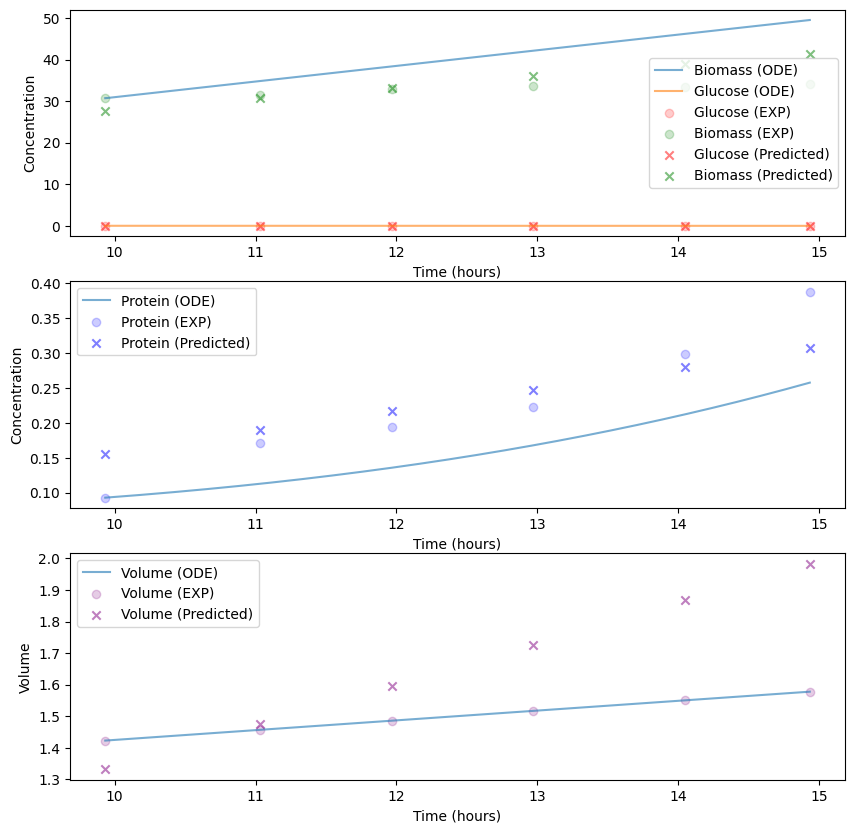

In [30]:
i = 7
print(f'Running for {i} data points')
df_ = df.iloc[:i]
net, net_df = main(df_, num_epochs=1000)

In [33]:
print(f'c1={net.c1.item()}, c2={net.c2.item()}')

c1=0.02580498345196247, c2=0.00022022186021786183


In [34]:
net_df

,RTime,Biomass,Glucose,V,Protein
0,9.933333,27.689905,0.013731,1.331354,0.155603
1,11.033333,30.692684,0.015610,1.474932,0.188943
2,11.966667,33.240501,0.017204,1.596755,0.217232
3,12.966667,35.970303,0.018912,1.727280,0.247542
4,14.050000,38.927578,0.020763,1.868682,0.280379
5,14.933333,41.338902,0.022272,1.983981,0.307154
